# EDA v2

In [1]:
import os
os.environ["SPARK_HOME"] = r"F:\DataScience\spark\spark-3.5.3-bin-hadoop3\spark-3.5.3-bin-hadoop3"
os.environ["HADOOP_HOME"] = r"F:\DataScience\hadoop\hadoop-3.4.0"
os.environ["HADOOP_CONF_DIR"] = r"F:\DataScience\hadoop\hadoop-3.4.0\etc\hadoop"

import findspark
import pickle
import pandas as pd
import numpy as np


findspark.init()


from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").config("spark.executor.memory", "8g").appName("PySpark").getOrCreate()

In [2]:
import re
from pyspark.sql.functions import explode
from pyspark.sql.functions import size, max as spark_max, min as spark_min, avg, isnan
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import sum, when
from pyspark.sql.functions import date_format, from_unixtime, year
from pyspark.sql import functions as F

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

In [3]:
from analytics_functions import metadata_analytics_treatment

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Carga de data

In [5]:
# Rutina para leer todos los archivos.
folder_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios"

count_record = 0

for file_name in os.listdir(folder_path):
    
    # recuperamos el nombre de cada archivo.
    file_path = os.path.join(folder_path, file_name)
  
    # primera lectura: se toma el esquema y se fuerza en los demas archivos.
    if count_record == 0:
        df = spark.read.json(file_path)
        schema = df.schema
        df_ETLed = metadata_analytics_treatment(df)        
        union_df = df_ETLed.select("*")
    # lecturas posteriores: se fuerza esquema, se anexa dataframe.
    else:
        df = spark.read.schema(schema).json(file_path)
        df_ETLed = metadata_analytics_treatment(df)
        union_df = union_df.union(df_ETLed)

    count_record+=1
    print("Iteración: ", count_record)

Iteración:  1
Iteración:  2
Iteración:  3
Iteración:  4
Iteración:  5
Iteración:  6
Iteración:  7
Iteración:  8
Iteración:  9
Iteración:  10
Iteración:  11


In [6]:
# Cargamos en cache nuestro dataframe.
union_df_cached = union_df.cache()

In [7]:
union_df_cached.show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------------+-------------------------------------+------------------+-------------------+--------------+-----+-------------------+
|avg_rating|category                                                                                                |gmap_id                              |latitude          |longitude          |num_of_reviews|state|city               |
+----------+--------------------------------------------------------------------------------------------------------+-------------------------------------+------------------+-------------------+--------------+-----+-------------------+
|5.0       |[Business to business service]                                                                          |0x405532c73fa7ce23:0x543f583f2cf17d6f|45.519880699999995|-122.67516889999999|4             |OR   |Portland           |
|4.3       |[Consignment shop]                          

In [8]:
# Tenemos un ttotal de 2.9millones de entradas.
union_df_cached.count()

2918918

### 2. Identificación de categorias.
Vamos a obtener todas las categorias existentes y filtrar las que nos interesan 

In [9]:
union_df_cached.printSchema()

root
 |-- avg_rating: double (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- gmap_id: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)



Hacemos un explode de la columna categorias y agrupamos por categorias.

In [10]:
category_df = union_df_cached.select("gmap_id", explode("category").alias("expanded_category"), "avg_rating", "num_of_reviews")\
    .groupBy("expanded_category").agg(F.count("gmap_id").alias("business_total"),
                                      F.avg("avg_rating").alias("avg_rating"),
                                      F.sum("num_of_reviews").alias("total_reviews"))
category_df.cache()

DataFrame[expanded_category: string, business_total: bigint, avg_rating: double, total_reviews: bigint]

In [11]:
category_df.count()

4461

In [12]:
# visualizacion
category_df.show()

+--------------------+--------------+------------------+-------------+
|   expanded_category|business_total|        avg_rating|total_reviews|
+--------------------+--------------+------------------+-------------+
|         Art gallery|          8545|4.6628086600351155|       213165|
|Public relations ...|           396| 4.592171717171718|         4512|
|          Tile store|          3038| 4.458294930875572|       106292|
|Sports massage th...|          3735| 4.579384203480582|       180087|
| Dry wall contractor|          1199|  4.39374478732277|        28402|
|     Debt collecting|            68|3.2661764705882352|         3531|
|North Eastern Ind...|            15| 4.153333333333332|         1781|
|Wedding dress ren...|            50| 4.454000000000001|         3336|
|     Basketball club|           209| 4.445454545454544|         7378|
|Central American ...|           106| 4.291509433962265|        16279|
|  Data entry service|            15| 4.366666666666666|          259|
|     

In [13]:
category_df_pandas = category_df.toPandas()

In [14]:
# Vamos a verificar las estadísticas.
category_df_pandas.describe()
# Observamos diferencias grandes con lo que respecta total de establecimientos y reviews.

,business_total,avg_rating,total_reviews
count,4461.000000,4461.000000,4.461000e+03
mean,1341.919973,4.349592,8.351836e+04
std,4339.473007,0.367156,3.331325e+05
min,1.000000,1.000000,1.000000e+00
25%,21.000000,4.221124,5.990000e+02
50%,155.000000,4.422581,5.588000e+03
75%,833.000000,4.573443,3.838300e+04
max,96525.000000,5.000000,1.095220e+07


In [15]:
category_df_pandas.sort_values(by='business_total', ascending=False).head(10)

,expanded_category,business_total,avg_rating,total_reviews
3007,Restaurant,96525,4.145516,10952202
3051,Auto repair shop,77073,4.441496,4256982
2304,Gas station,69668,3.835329,1809360
854,Beauty salon,64889,4.538418,2672819
4061,Convenience store,61629,3.597853,1683959
744,Church,52560,4.660327,741668
619,Hair salon,51102,4.540008,2394668
4226,Nail salon,44141,4.249392,2769006
3496,Park,42142,4.380938,2004341
689,ATM,42019,3.578000,807803


<Axes: xlabel='business_total'>

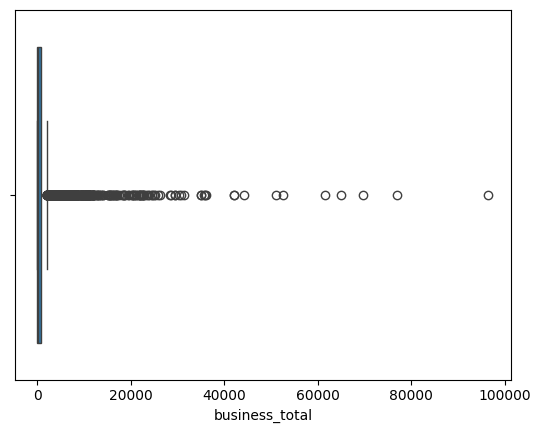

In [16]:
sns.boxplot(data=category_df_pandas, x= 'business_total')

<Axes: xlabel='total_reviews'>

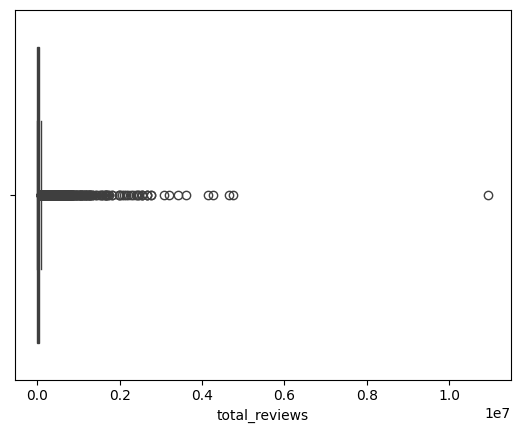

In [17]:
sns.boxplot(data=category_df_pandas, x= 'total_reviews')

Según lo observado tanto en los boxplot , asi como en el output de describe, existen muchas categorias, pero solo unas cuantas son las que se repiten en gran mayoria. Estas categorías son las que realmente nos interesan.

In [18]:
# Aplicamos un filtro para segmentar las categorias con datos relevantes.
category_df_pandas_filtered = category_df_pandas[category_df_pandas["business_total"]>1000]
category_df_pandas_filtered = category_df_pandas_filtered.sort_values(by='business_total', ascending=False)
category_df_pandas_filtered = category_df_pandas_filtered.reset_index(drop=True)
category_df_pandas_filtered.head(30)

,expanded_category,business_total,avg_rating,total_reviews
0,Restaurant,96525,4.145516,10952202
1,Auto repair shop,77073,4.441496,4256982
2,Gas station,69668,3.835329,1809360
3,Beauty salon,64889,4.538418,2672819
4,Convenience store,61629,3.597853,1683959
5,Church,52560,4.660327,741668
6,Hair salon,51102,4.540008,2394668
7,Nail salon,44141,4.249392,2769006
8,Park,42142,4.380938,2004341
9,ATM,42019,3.578000,807803


In [ ]:
#category_df_pandas_filtered.iloc[990:].head(20)

"""
['Family restaurant', 'Juice shop', 'Chicken wings restaurant', 'Barbecue restaurant', 'Chicken restaurant',  'Coffee store', 'Snack bar', 
 'Health food restaurant', 'Espresso bar', 'Sushi restaurant', 'Bagel shop', 'Cake shop', 'Taco restaurant', 'Lunch restaurant', 'Salad shop', 
 'Vegetarian restaurant', 'Thai restaurant', 'Latin American restaurant', 'Vegan restaurant', 'Indian restaurant', 'Brunch restaurant', 'Dessert restaurant',
'Bubble tea store', 'Takeout restaurant', 'Asian fusion restaurant', 'Tex-Mex restaurant',  'Burrito restaurant', 'Buffet restaurant', 'Korean restaurant',
 'Southern restaurant (US)'   ]
 """

['Family restaurant',
 'Juice shop',
 'Chicken wings restaurant',
 'Barbecue restaurant',
 'Chicken restaurant',
 'Coffee store',
 'Snack bar',
 'Health food restaurant',
 'Espresso bar',
 'Sushi restaurant',
 'Bagel shop',
 'Cake shop',
 'Taco restaurant',
 'Lunch restaurant',
 'Salad shop',
 'Vegetarian restaurant',
 'Thai restaurant',
 'Latin American restaurant',
 'Vegan restaurant',
 'Indian restaurant',
 'Brunch restaurant',
 'Dessert restaurant',
 'Bubble tea store',
 'Takeout restaurant',
 'Asian fusion restaurant',
 'Tex-Mex restaurant',
 'Burrito restaurant',
 'Buffet restaurant',
 'Korean restaurant',
 'Southern restaurant (US)']

Text(0.5, 1.0, 'Total negocios por categorias')

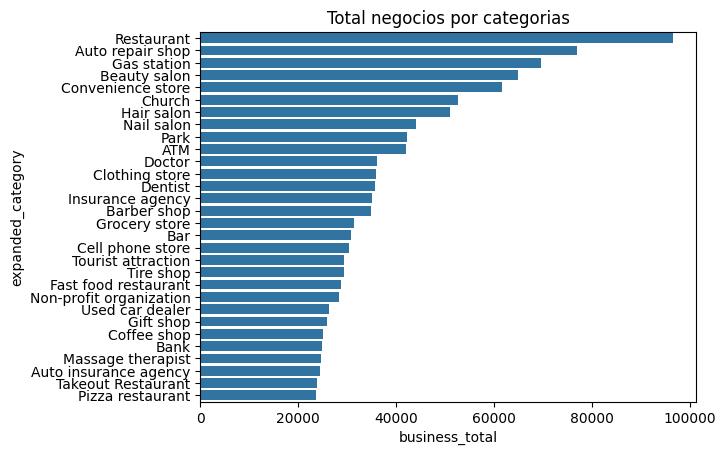

In [27]:
# Gráfica general de categorias.
sns.barplot(category_df_pandas_filtered.head(30), x='business_total', y='expanded_category').set_title('Total negocios por categorias')

Generamos un wordcloud para explorar las palabras que mas se repiten 

In [21]:
from wordcloud import WordCloud

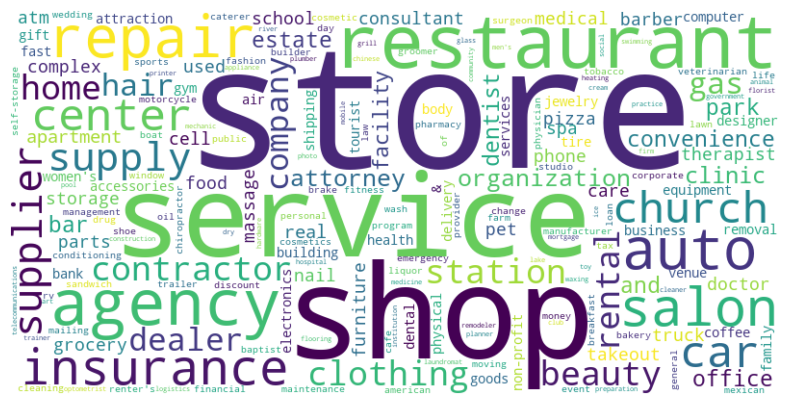

In [22]:
wordcloud_food_df = category_df_pandas_filtered.copy()
wordcloud_food_df["expanded_category"] = wordcloud_food_df["expanded_category"].str.lower()
wordcloud_food_df["word"] = wordcloud_food_df["expanded_category"].str.split()
wordcloud_food_df = wordcloud_food_df.explode('word').reset_index(drop=True)
wordcloud_food_df.drop(columns=['expanded_category', 'avg_rating', 'total_reviews'],inplace=True)
wordcloud_food_df.rename(columns={'business_total': 'frequency'}, inplace=True)
wordcloud_food_df = wordcloud_food_df.groupby(by='word').sum().reset_index()

frequencies = dict(zip(wordcloud_food_df['word'], wordcloud_food_df['frequency']))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nos interesa filtrar negocios asociados a comida, ya que es el rubro que le interesa a nuestro cliente. 

In [28]:
food_keywords = ['Restaurant', 'Fast food restaurant', 'Coffee shop', 'Takeout Restaurant', 'Pizza restaurant', 'Sandwich shop', 'Cafe', 'Bakery',
                 'Mexican restaurant', 'American restaurant', 'Breakfast restaurant', 'Delivery Restaurant', 'Chinese restaurant', 'Bar & grill',
                 'Italian restaurant', 'Pizza delivery', 'Dessert shop', 'Pizza Takeout', 'Hamburger restaurant', 'Seafood restaurant', 'Donut shop',
                 'Asian restaurant', 'Juice shop', 'Family restaurant', 'Juice shop', 'Chicken wings restaurant', 'Barbecue restaurant', 'Chicken restaurant',  'Coffee store', 'Snack bar', 
                'Health food restaurant', 'Espresso bar', 'Sushi restaurant', 'Bagel shop', 'Cake shop', 'Taco restaurant', 'Lunch restaurant', 'Salad shop', 
                'Vegetarian restaurant', 'Thai restaurant', 'Latin American restaurant', 'Vegan restaurant', 'Indian restaurant', 'Brunch restaurant', 'Dessert restaurant',
                'Bubble tea store', 'Takeout restaurant', 'Asian fusion restaurant', 'Tex-Mex restaurant',  'Burrito restaurant', 'Buffet restaurant', 'Korean restaurant',
                'Southern restaurant (US)'   ]

In [98]:
len(food_keywords)

53

In [29]:
food_categories_df = category_df_pandas_filtered[category_df_pandas_filtered['expanded_category'].isin(food_keywords)].reset_index(drop=True)

In [34]:
# Dropeamos la categoria 'Restaurante'
food_categories_df = food_categories_df.drop(0)
food_categories_df

,expanded_category,business_total,avg_rating,total_reviews
1,Fast food restaurant,28657,3.821241,4751943
2,Coffee shop,25167,4.155382,2329230
3,Takeout Restaurant,23810,3.889857,1990291
4,Pizza restaurant,23694,4.030670,2549724
5,Sandwich shop,22719,3.937761,2479504
6,Cafe,20311,4.303082,1434464
7,Bakery,18539,4.294104,1424415
8,Mexican restaurant,17074,4.207567,2451184
9,American restaurant,17072,4.097739,4650189
10,Breakfast restaurant,13132,3.985988,3205460


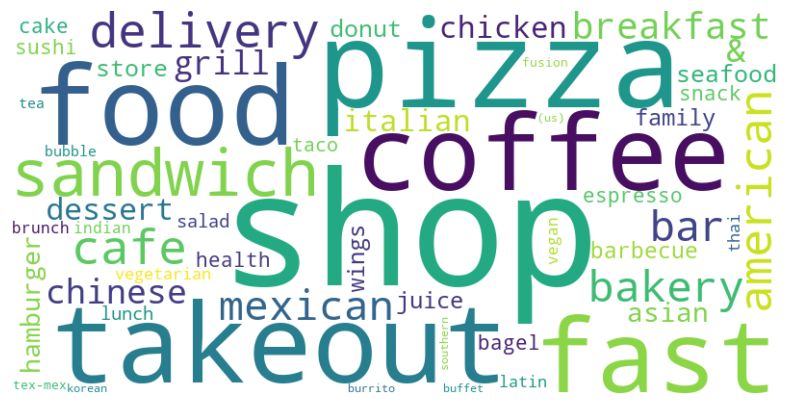

In [36]:
# wordlcoud foodcategoria


wordcloud_food_df = food_categories_df.copy()
wordcloud_food_df["expanded_category"] = wordcloud_food_df["expanded_category"].str.lower()
wordcloud_food_df["word"] = wordcloud_food_df["expanded_category"].str.split()
wordcloud_food_df = wordcloud_food_df.explode('word').reset_index(drop=True)
wordcloud_food_df.drop(columns=['expanded_category', 'avg_rating', 'total_reviews'],inplace=True)
wordcloud_food_df.rename(columns={'business_total': 'frequency'}, inplace=True)
wordcloud_food_df = wordcloud_food_df.groupby(by='word').sum().reset_index()
wordcloud_food_df = wordcloud_food_df.drop(37)

frequencies = dict(zip(wordcloud_food_df['word'], wordcloud_food_df['frequency']))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\Une\AppData\Local\Temp\ipykernel_14016\1118273182.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=food_categories_df.head(30), x='business_total', y='expanded_category', palette=colors).set_title('Total negocios por categoria de comida')
C:\Users\Une\AppData\Local\Temp\ipykernel_14016\1118273182.py:6: UserWarning: The palette list has more values (51) than needed (30), which may not be intended.
  sns.barplot(data=food_categories_df.head(30), x='business_total', y='expanded_category', palette=colors).set_title('Total negocios por categoria de comida')


Text(0.5, 1.0, 'Total negocios por categoria de comida')

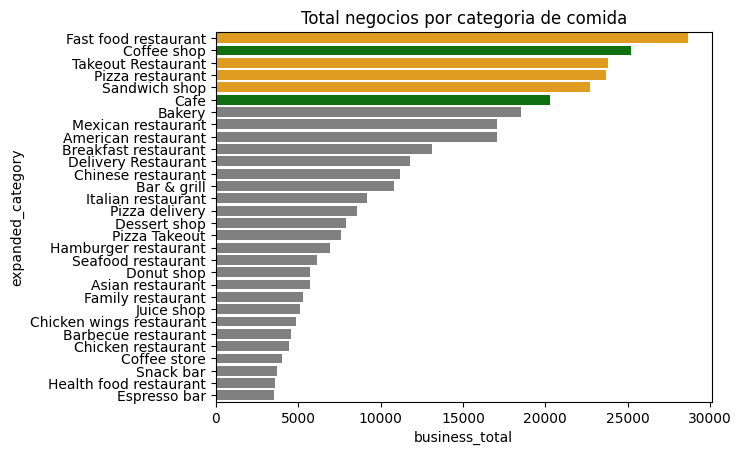

In [38]:
# Creamos una paleta de colores
highlight = ['Coffee shop', 'Cafe']
highlight_2 = ['Pizza restaurant', 'Takeout Restaurant', 'Sandwich shop', 'Fast food restaurant']
colors = ["green" if cat in highlight else "orange" if cat in highlight_2 else "gray" for cat in food_categories_df["expanded_category"]]
# Graficamos
sns.barplot(data=food_categories_df.head(30), x='business_total', y='expanded_category', palette=colors).set_title('Total negocios por categoria de comida')

C:\Users\Une\AppData\Local\Temp\ipykernel_14016\2054242476.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= graph_data, x='avg_rating', y='expanded_category',  palette=colors).set_title('Media rating por categoria de comida')


Text(0.5, 1.0, 'Media rating por categoria de comida')

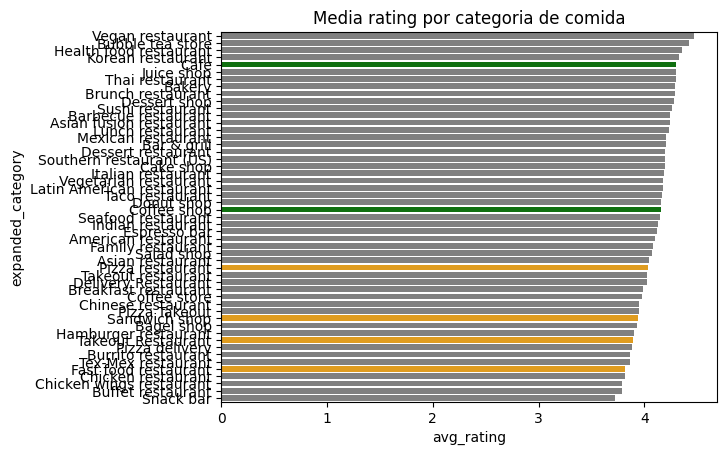

In [66]:
# Creamos una paleta de colores
graph_data = food_categories_df.sort_values(by='avg_rating', ascending=False)
highlight = ['Coffee shop', 'Cafe']
highlight_2 = ['Pizza restaurant', 'Takeout Restaurant', 'Sandwich shop', 'Fast food restaurant']
colors = ["green" if cat in highlight else "orange" if cat in highlight_2 else "gray" for cat in graph_data["expanded_category"]]

sns.barplot(data= graph_data, x='avg_rating', y='expanded_category',  palette=colors).set_title('Media rating por categoria de comida')

In [45]:
graph_data.drop(columns=['expanded_category']).corr()

,business_total,avg_rating,total_reviews
business_total,1.000000,-0.175325,0.785191
avg_rating,-0.175325,1.000000,-0.274624
total_reviews,0.785191,-0.274624,1.000000


In [ ]:
# Guardamos el dataset en caso sea necesario consultarlo posteriormente.
category_df_pandas.to_csv(r"F:\DataScience\PF - DataNova\datasets\Google Maps\distinct-categories.csv",index=False)

In [48]:
category_df_pandas=pd.read_csv(r"F:\DataScience\PF - DataNova\datasets\Google Maps\distinct-categories.csv")

In [49]:
# Vamos a crear un diccionar con palabras clave para filtrar las categorias deseadas

#palabras que deseamos incluir
keywords_dict = {
    "coffee_related": ["coffee", "espresso", "latte", "cafe"],
    "breakfast_related": ["breakfast", "brunch", "morning"],
    "bakery_related": ["bakery", "pastry"],
    "tea_related": ["tea", "matcha", "teahouse"]
}

# Esta lista de exclusión se toma de las palabras que deseamos excluir. Por ejemplo, proveedores, manufacturers, y otras
# posibles coincidencias que no deseamos incluir.
exclude_list = ["church", "internet", "roasters", "stand", "wholesaler", 
                "supplier", "machine", "dog", "childrens", "merchant", "cosplay", "bed",
                "wedding", "wholesale", "equipment", "steak", "cheesesteak", "manufacturer", "market place", "steamed", 
                "exporter", "teacher", "plateau", "steamboat"]

In [50]:
# Inicializamos un dataframe con la estructura final.
filtered_dataframe = pd.DataFrame(columns=["expanded_category", "business_total", "business_type"])

# Creamos un loop para anexar las categorias.
for key, key_list in keywords_dict.items():
    filtered_categories = category_df_pandas[category_df_pandas["expanded_category"].apply(str.lower)\
                                         .str.contains("|".join(key_list))]\
                                            .sort_values(by="business_total", ascending=False)
    
    filtered_categories = filtered_categories[~filtered_categories["expanded_category"]\
                                              .apply(str.lower).str.contains("|".join(exclude_list))]
    
    filtered_categories["business_type"] = key

    filtered_dataframe = pd.concat([filtered_dataframe, filtered_categories])

In [51]:
filtered_dataframe

,expanded_category,business_total,business_type,avg_rating,total_reviews
1116,Coffee shop,25167,coffee_related,4.155382,2329230.0
3897,Cafe,20311,coffee_related,4.303082,1434464.0
2961,Coffee store,4033,coffee_related,3.980684,290247.0
1544,Espresso bar,3524,coffee_related,4.120829,320061.0
117,Cafeteria,622,coffee_related,4.102412,57442.0
1734,Vegetarian cafe and deli,188,coffee_related,4.556383,13391.0
1243,Art cafe,151,coffee_related,4.714570,6142.0
1257,Restaurant or cafe,118,coffee_related,4.250847,3021.0
4098,Chocolate cafe,84,coffee_related,4.702381,4190.0
2908,Comic cafe,12,coffee_related,4.491667,772.0


In [ ]:
grouped_df = filtered_dataframe.groupby(by="business_type").agg(total_business=("business_total", "sum")).reset_index().sort_values(by="total_business", ascending=False)
grouped_df

,business_type,total_business
2,coffee_related,54214
0,bakery_related,19926
1,breakfast_related,15160
3,tea_related,4906


<Axes: xlabel='business_type', ylabel='total_business'>

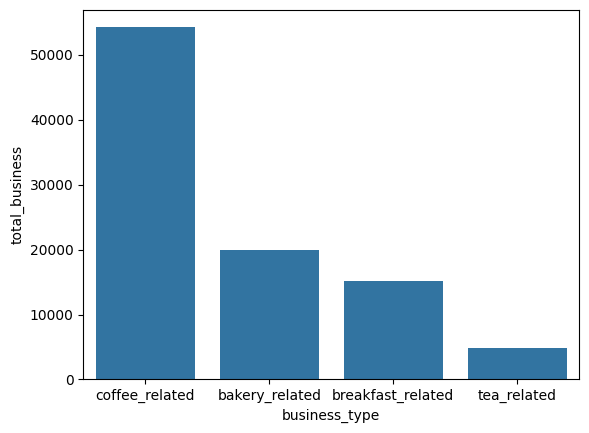

In [ ]:
sns.barplot(data=grouped_df, x="business_type", y="total_business",)

Tenemos un total de 54214 negocios de tipo coffee.
Tenemos otros posiblemente asociados a bakery, breakfast y tea.

### 3. Extracción de negocios con las categorias deseadas

In [68]:
# Creamos una lista que que usaremos filtrar nuestro union_df.
list_category = list(filtered_dataframe["expanded_category"])
allowed_categories_str = ", ".join([f"'{c}'" for c in list_category])
allowed_categories_str

"'Coffee shop', 'Cafe', 'Coffee store', 'Espresso bar', 'Cafeteria', 'Vegetarian cafe and deli', 'Art cafe', 'Restaurant or cafe', 'Chocolate cafe', 'Comic cafe', 'Coffee', 'Breakfast restaurant', 'Brunch restaurant', 'Bakery', 'Pastry shop', 'Chinese bakery', 'Tea house', 'Bubble tea store', 'Tea store', 'Chinese tea house', 'Traditional teahouse'"

In [69]:
# Aplicamos el filtro con la funcion expr de spark, y array_intersect.
filtered_union_df = union_df_cached.filter(
    col("category").isNotNull() &
    F.expr(f"size(array_intersect(category, array({allowed_categories_str}))) > 0")
)

In [70]:
filtered_union_df.show(truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+------------------+-------------------+--------------+-----+----------------+
|avg_rating|category                                                                                                                                   |gmap_id                              |latitude          |longitude          |num_of_reviews|state|city            |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+------------------+-------------------+--------------+-----+----------------+
|5.0       |[Cafe]                                                                                                                                     |0x4cae4b5f86d43b03:0xb38283b05c370d0f|44.799

In [71]:
#63k negocios
filtered_union_df.count()

63168

In [ ]:
# Pasamos a pandas y guardamos
focused_business_df_2 = filtered_union_df.toPandas()
focused_business_df_2.to_parquet(r"F:\DataScience\PF - DataNova\datasets\Google Maps\focused-business-v2.parquet", index=False)

In [34]:
## De ser necesario, aplicar las categorias al dataframe
"""
condition = None

filtered_union_df_test = filtered_union_df.withColumn("category_str", F.concat_ws(" ", col("category")))

for label, keywords in keywords_dict.items():
    # Crear una condición para esta categoría
    regex_pattern = "|".join([f"(?i)\\b{keyword}\\b" for keyword in keywords])

    category_condition = None
    category_condition = col("category_str").rlike(regex_pattern)
    
    if condition is None:
        condition = when(category_condition, F.lit(label))
    else:
        condition = condition.when(category_condition, F.lit(label))

# Agregar una columna con el valor "Other" si no coincide con ninguna categoría
condition = condition.otherwise(F.lit("Other"))

# Crear la nueva columna basada en la condición
filtered_union_df_wlabels = filtered_union_df_test.withColumn("computed_category", condition)
"""

'\ncondition = None\n\nfiltered_union_df_test = filtered_union_df.withColumn("category_str", F.concat_ws(" ", col("category")))\n\nfor label, keywords in keywords_dict.items():\n    # Crear una condición para esta categoría\n    regex_pattern = "|".join([f"(?i)\\b{keyword}\\b" for keyword in keywords])\n\n    category_condition = None\n    category_condition = col("category_str").rlike(regex_pattern)\n    \n    if condition is None:\n        condition = when(category_condition, F.lit(label))\n    else:\n        condition = condition.when(category_condition, F.lit(label))\n\n# Agregar una columna con el valor "Other" si no coincide con ninguna categoría\ncondition = condition.otherwise(F.lit("Other"))\n\n# Crear la nueva columna basada en la condición\nfiltered_union_df_wlabels = filtered_union_df_test.withColumn("computed_category", condition)\n'

### 4. Cruce con reviews

In [72]:
# Lista de gmap_id que deseamos filtrar en los reviews.
business_id_df = filtered_union_df.select("gmap_id")
business_id_df.show(truncate=False)

+-------------------------------------+
|gmap_id                              |
+-------------------------------------+
|0x4cae4b5f86d43b03:0xb38283b05c370d0f|
|0x80c2c351322c1e1f:0xcdbd2a02ed207d2b|
|0x80dcd5042565798f:0xbb440a8360a68f29|
|0x8640bde90af10eab:0x89294f206b137047|
|0x864e9d787aa3ae67:0xf2af22f6b3e16eff|
|0x872ba7e174d0d45d:0xb21fcedbd9a41c4 |
|0x87e8147bc929a82f:0xe8af0adcd10ed5ab|
|0x880f712317311a11:0x5f15c93c3397c2db|
|0x883b7d989dc851b9:0xb191105434b441ad|
|0x8866162835bcd35d:0x6ae87e9b736e0eb1|
|0x89e37b245ed9ebfb:0x4b9dea207bacd315|
|0x53329934f18c107b:0xc3b29335b431316e|
|0x54905ea19e8dca37:0xd895ddb13d5265ab|
|0x795160a69ba7945d:0xa2310dcbeafa267d|
|0x808fa217d0b7498b:0x4cdfc105cb481a4d|
|0x80dc070b44ba9373:0x94dc3ca90971ed9b|
|0x80dc72f709bb8a3f:0x6e32585b5d411608|
|0x8644b5ebf0f5d40b:0xf230a8612b73f84f|
|0x864c029de37ed055:0x70b6d02fa44177a3|
|0x87134550d415a4bf:0xf177e8eab64759c8|
+-------------------------------------+
only showing top 20 rows



Debido a que son 51 estados y cerca de 24 gigas en total, información que no podemos cargar en memoria, vamos a crear un plan de analisis por estado y luego resumir data con técnicas de agregación por estado

In [52]:
# Definimos la ruta donde se encuentra los archivos.
reviews_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados"
folders = [name for name in os.listdir(reviews_path) if os.path.isdir(os.path.join(reviews_path, name))]
len(folders)

51

In [16]:
files_path = reviews_path+ "\\" + folders[5] 
files_path

'F:\\DataScience\\PF - DataNova\\datasets\\Google Maps\\reviews-estados\\review-Colorado'

In [65]:
# Contamos la cantidad total de reviews:
count_reviews = 0

dir_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados"
for folder in os.listdir(dir_path):
    state_folder = dir_path + "\\"+folder
    print('reading ', state_folder)
    for file in os.listdir(state_folder):
        file_path= state_folder + "\\" +file
        df = spark.read.json(file_path)
        count_reviews = count_reviews + df.count()

print('total reviews: ', count_reviews)

reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Alabama
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Alaska
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Arizona
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Arkansas
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-California
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Colorado
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Connecticut
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Delaware
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-District_of_Columbia
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\review-Florida
reading  F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\rev

In [53]:
# Rutina para leer archivos dentro de la carpeta.

def batch_file_read(folder_path):
    "Lee varios archivos JSON dentro de una carpeta especifica, output: Dataframe Spark."
    count_record = 0

    for file_name in os.listdir(folder_path):
        
        # recuperamos el nombre de cada archivo.
        file_path = os.path.join(folder_path, file_name)
    
        # primera lectura: se toma el esquema y se fuerza en los demas archivos.
        if count_record == 0:
            df = spark.read.json(file_path)
            schema = df.schema      
            union_df = df.select("*")
        # lecturas posteriores: se fuerza esquema, se anexa dataframe.
        else:
            df = spark.read.schema(schema).json(file_path)
            union_df = union_df.union(df)

        count_record+=1
        #print("Iteración: ", count_record)
    
    return union_df

In [18]:
reviews_df = batch_file_read(files_path)

In [19]:
reviews_df.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [60]:
reviews_df.show()

+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|             gmap_id|                name|pics|rating|                resp|                text|         time|             user_id|
+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|0x876c75945568003...|         mgshouldice|NULL|     3|                NULL|Don't mix this up...|1484353876202|10899045731676311...|
|0x876c75945568003...|   Sabrina Holsinger|NULL|     4|                NULL|Teachers are grea...|1484195642287|10740396647478613...|
|0x876c75945568003...|           Tad Amore|NULL|     5|                NULL|Great school can'...|1459554530689|11281981894504357...|
|0x876c75945568003...|Victoria Elizabet...|NULL|     1|                NULL|                NULL|1483746469128|10259175743371735...|
|0x876c75945568003...|   Luis Garcia-Lopez|NULL|     5|              

- Columnas a remover para nuestro análisis EDA: 
    - name (nombre del usuario)
    - user_id (id del usuario)
    - pics (fotos)
    - resp (respuestas al review): se puede usar luego para sentiment analysis

In [73]:
def state_df_treatment(spark_df):
    spark_df = spark_df.drop(*["name", "pics", "user_id", "resp"])
    spark_df = spark_df.withColumn("formatted_time", from_unixtime(col("time") / 1000))
    spark_df = spark_df.withColumn("year", year(col("formatted_time")))
    spark_df = spark_df.drop("time")
    return spark_df

In [75]:
# Vamos a mapear los estados a sus respectivos nombres.
STATE_MAPPER = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District_of_Columbia",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New_Hampshire",
    "NJ": "New_Jersey",
    "NM": "New_Mexico",
    "NY": "New_York",
    "NC": "North_Carolina",
    "ND": "North_Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode_Island",
    "SC": "South_Carolina",
    "SD": "South_Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West_Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}

Aqui creamos un loop para iterar sobre todos las carpetas, hacer un join con los negocios del estado, y luego crear un nuevo dataframe.

In [ ]:
reviews_path = r"F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados"

#filtered_union_df = dataset de negocios que nos interesan.

for state_code, state_name in STATE_MAPPER.items():
    
    print("Proccessing: ", state_name, end="")

    file_path = reviews_path+"\\"+"review-"+state_name
    
    state_reviews_df = batch_file_read(file_path)
    state_reviews_df = state_df_treatment(state_reviews_df)
    
    filtered_state_reviews_df = state_reviews_df.join(\
        filtered_union_df.filter((filtered_union_df["state"]==state_code)).select("gmap_id"), on="gmap_id", how="inner")

    filtered_state_reviews_df_pd = filtered_state_reviews_df.toPandas()
    filtered_state_reviews_df_pd.to_parquet(r"F:\DataScience\PF - DataNova\datasets\summarized\google\\"+state_name+"_summ.parquet" ,index=False)
    
    print("...ok")

In [77]:
def batch_file_read_parquet(folder_path):
    "Lee varios archivos PARQUET dentro de una carpeta especifica, output: Dataframe Spark."
    count_record = 0

    for file_name in os.listdir(folder_path):
        
        # recuperamos el nombre de cada archivo.
        file_path = os.path.join(folder_path, file_name)
    
        # primera lectura: se toma el esquema y se fuerza en los demas archivos.
        if count_record == 0:
            df = spark.read.parquet(file_path)
            schema = df.schema      
            union_df = df.select("*")
        # lecturas posteriores: se fuerza esquema, se anexa dataframe.
        else:
            df = spark.read.schema(schema).parquet(file_path)
            union_df = union_df.union(df)

        count_record+=1
        #print("Iteración: ", count_record)
    
    return union_df

In [78]:
filtered_reviews_df = batch_file_read_parquet(r"F:\DataScience\PF - DataNova\datasets\summarized\google")

In [79]:
filtered_reviews_df_cached  = filtered_reviews_df.cache()

In [80]:
# Total de 3,3M de comentarios.
filtered_reviews_df_cached.count()

3322223

In [82]:
filtered_reviews_df_cached = filtered_reviews_df_cached.withColumn('date_time', F.to_timestamp("formatted_time", "yyyy-MM-dd HH:mm:ss"))
filtered_reviews_df_cached = filtered_reviews_df_cached.drop('formatted_time')
filtered_reviews_df_cached.show()

+--------------------+------+--------------------+----+-------------------+
|             gmap_id|rating|                text|year|          date_time|
+--------------------+------+--------------------+----+-------------------+
|0x888ed207dee87cf...|     4|Love the store an...|2020|2020-12-11 22:11:01|
|0x888ed207dee87cf...|     5|Authentic Mexican...|2018|2018-09-02 19:57:16|
|0x888ed207dee87cf...|     5|Outstanding baked...|2018|2018-05-06 15:11:54|
|0x888ed207dee87cf...|     5|            😉🤔🙄😏|2019|2019-06-27 12:10:01|
|0x888ed207dee87cf...|     5|(Translated by Go...|2020|2020-11-22 14:30:54|
|0x888ed207dee87cf...|     5|(Translated by Go...|2020|2020-01-04 19:38:38|
|0x888ed207dee87cf...|     5|(Translated by Go...|2020|2020-09-06 16:19:35|
|0x888ed207dee87cf...|     3|(Translated by Go...|2019|2019-11-01 03:51:59|
|0x888ed207dee87cf...|     5|(Translated by Go...|2018|2018-09-08 11:54:45|
|0x888ed207dee87cf...|     5|(Translated by Go...|2019|2019-07-01 06:10:24|
|0x888ed207dee87

In [83]:
# Observamos un comentario de 1990, debe ser un error.
# Observamos que los ratings son números enteros del 1 al 5.
# Hay gran cantidad de textos nulos. Es decior, sin comentarios pero con calificacion.
filtered_reviews_df_cached.describe().show()

+-------+--------------------+------------------+--------------------+------------------+
|summary|             gmap_id|            rating|                text|              year|
+-------+--------------------+------------------+--------------------+------------------+
|  count|             3322223|           3322223|             1891240|           3322223|
|   mean|                NULL| 4.202251624890924|                54.0|  2018.70015077254|
| stddev|                NULL|1.1622800852052677|   65.05382386916237|1.3849168791243809|
|    min|0x1458b9a7e527705...|                 1| The atmosphere i...|              1990|
|    max|0x89fca7af1a66751...|                 5|🧡 this place. Ne...|              2021|
+-------+--------------------+------------------+--------------------+------------------+



In [84]:
filtered_reviews_df_cached.select('*').filter(filtered_reviews_df_cached["year"]==1990).show()

+--------------------+------+--------------------+----+-------------------+
|             gmap_id|rating|                text|year|          date_time|
+--------------------+------+--------------------+----+-------------------+
|0x808580db268326a...|     4|The decor is the ...|1990|1990-12-30 19:00:00|
|0x89c2598520997dd...|     4|Weekend brunch (~...|1990|1990-12-30 19:00:00|
|0x89c259a13f73f8c...|     4|Very good Italian...|1990|1990-12-30 19:00:00|
|0x89c25a1e252c2f3...|     4|Pleasant, but not...|1990|1990-12-30 19:00:00|
|0x89c2588ba15b33a...|     4|Authentic Spanish...|1990|1990-12-30 19:00:00|
+--------------------+------+--------------------+----+-------------------+



In [85]:
# Dropeamos los valores del año 1990. Parece un error en el sistema.
filtered_reviews_df_cached = filtered_reviews_df_cached.select('*').filter(filtered_reviews_df_cached["year"]!=1990)

In [86]:
# Fechas minimas y maximas del dataset:
filtered_reviews_df_cached.select("date_time").agg(
    F.min("date_time").alias('min_date'),
    F.max("date_time").alias('max_date'),
).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2002-04-18 19:00:00|2021-09-08 16:37:39|
+-------------------+-------------------+



In [87]:
filtered_reviews_df_cached_year_agg = filtered_reviews_df_cached.select('*').groupBy('year').agg(
    F.count('gmap_id').alias('total_reviews'),
    F.countDistinct('gmap_id').alias('distinct_business'),
    F.avg('rating').alias('avg_rating')
)

In [88]:
filtered_reviews_df_cached_year_agg.orderBy(col('year').asc()).show()

+----+-------------+-----------------+------------------+
|year|total_reviews|distinct_business|        avg_rating|
+----+-------------+-----------------+------------------+
|2002|            5|                5|               3.6|
|2003|            3|                3|               4.0|
|2004|           11|               10|3.5454545454545454|
|2005|           11|                9|3.5454545454545454|
|2006|           14|               12| 3.857142857142857|
|2007|           29|               25|3.8275862068965516|
|2008|           45|               38|3.7111111111111112|
|2009|           69|               60| 3.898550724637681|
|2010|         1017|              644|3.8997050147492627|
|2011|         3401|             1977|3.9897089091443694|
|2012|         3692|             2222| 4.069068255687974|
|2013|         5259|             3039| 4.067503327628827|
|2014|         6726|             3890| 4.004311626523937|
|2015|        20525|             8707| 4.023386114494519|
|2016|       1

Se observa que en el año 2020 hubo una reduccion significa de reviews, esto posiblemente debido al inicio de pandemia.
La fecha final del año 2021, es 2021-09-08. (8 de Septiembre)

In [89]:
# Visualización de evolución trimestral.
filtered_reviews_df_cached_Q_agg = filtered_reviews_df_cached.withColumn(
    "quarter",
    F.when(F.month("date_time").between(1, 3), "Q1")
    .when(F.month("date_time").between(4, 6), "Q2")
    .when(F.month("date_time").between(7, 9), "Q3")
    .when(F.month("date_time").between(10, 12), "Q4")
)

filtered_reviews_df_cached_Q_agg = filtered_reviews_df_cached_Q_agg.groupBy('year', 'quarter').agg(
    F.avg('rating').alias('avg_rating'),
    F.count('text').alias('total_reviews'),
    F.countDistinct('gmap_id').alias('distinct_id')
)


In [90]:
filtered_reviews_df_cached_Q_agg = filtered_reviews_df_cached_Q_agg.orderBy('year','quarter')
filtered_reviews_df_cached_Q_agg.show(200)

+----+-------+------------------+-------------+-----------+
|year|quarter|        avg_rating|total_reviews|distinct_id|
+----+-------+------------------+-------------+-----------+
|2002|     Q2|               3.6|            0|          5|
|2003|     Q1|               4.0|            0|          1|
|2003|     Q2|               4.0|            0|          2|
|2004|     Q1|               3.0|            0|          3|
|2004|     Q2|               3.5|            0|          4|
|2004|     Q4|               4.0|            3|          4|
|2005|     Q1|               4.0|            0|          1|
|2005|     Q2|3.4444444444444446|            4|          8|
|2005|     Q3|               4.0|            1|          1|
|2006|     Q1|               3.8|            4|          5|
|2006|     Q2|               4.0|            4|          6|
|2006|     Q3|               3.0|            1|          1|
|2006|     Q4|               4.0|            1|          1|
|2007|     Q1|               3.6|       

In [91]:
#Vamos a pasar a pandas para graficar
# Dropeamos el primer y ultimo dato, ya que no son periodos completos.
grouped_reviews_df = filtered_reviews_df_cached_Q_agg.toPandas()
grouped_reviews_df = grouped_reviews_df.drop([0,71])

Text(0.5, 1.0, 'Total Reviews por Periodo')

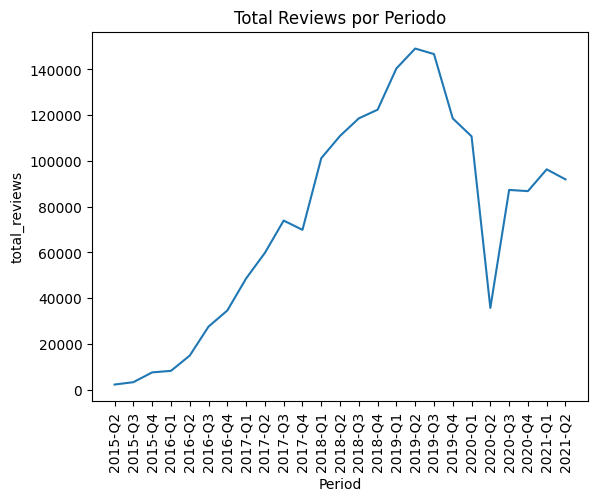

In [94]:
grouped_reviews_df["Period"] = grouped_reviews_df['year'].astype(str) + "-" + grouped_reviews_df['quarter']
#plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.lineplot(data=grouped_reviews_df.tail(25), x="Period", y='total_reviews').set_title('Total Reviews por Periodo')


Text(0.5, 1.0, 'Establecimientos(unicos) por Periodo')

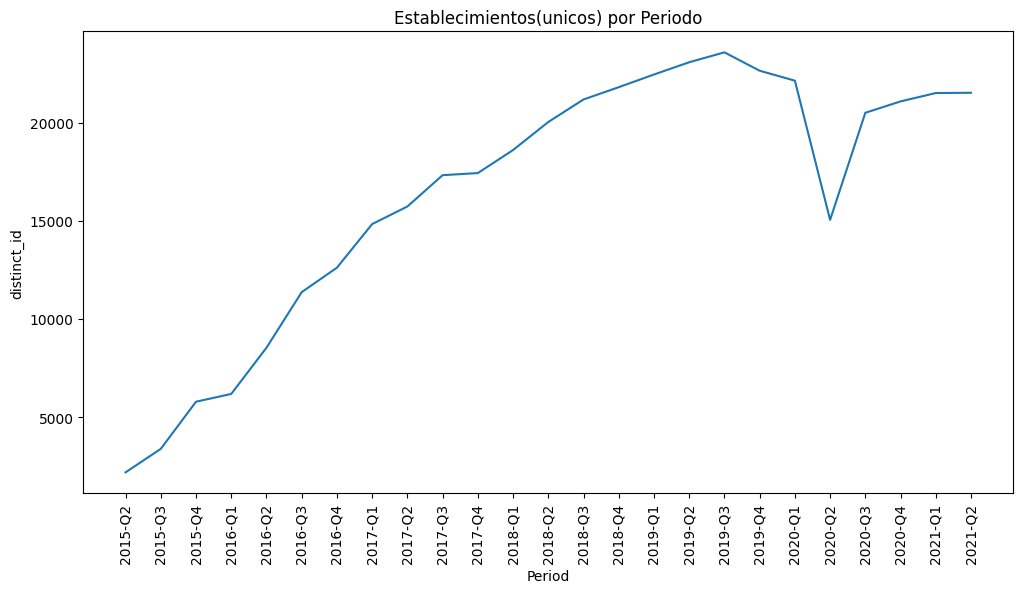

In [95]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.lineplot(data=grouped_reviews_df.tail(25), x="Period", y='distinct_id').set_title('Establecimientos(unicos) por Periodo')

Text(0.5, 1.0, 'Rating Promedio por periodo')

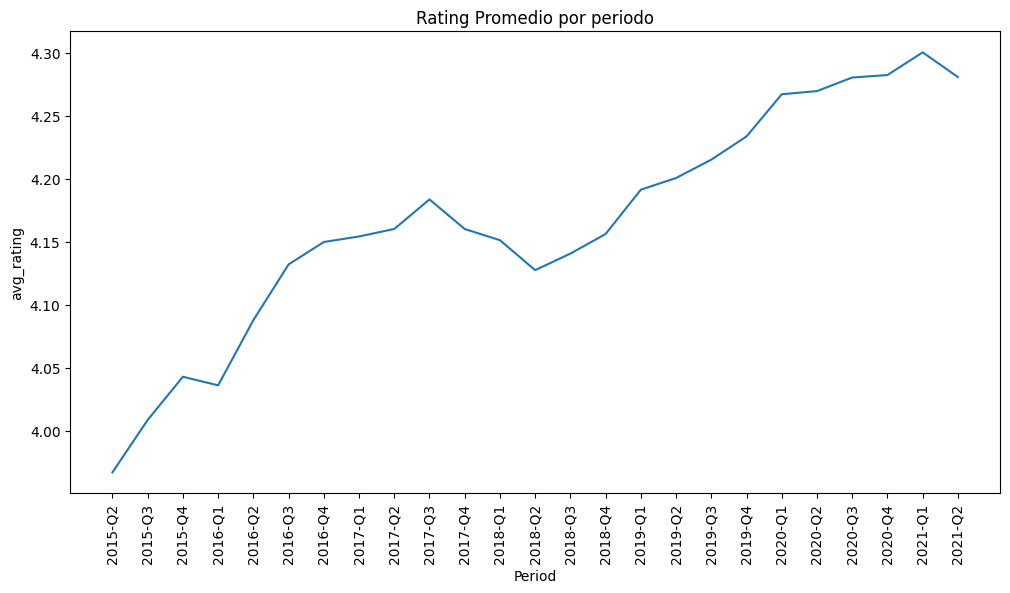

In [96]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.lineplot(data=grouped_reviews_df.tail(25), x="Period", y='avg_rating').set_title('Rating Promedio por periodo')

- Notamos un crecimiento constante del rubro, hasta llegar a periodo de pandemia. 
- Posteriormente vemos nueva alsa en los negocios.
- En general, el rating promedio ha ido en incremento para este rubro, a pesar de la pandemia.

In [162]:
grouped_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           72 non-null     int32  
 1   quarter        72 non-null     object 
 2   avg_rating     72 non-null     float64
 3   total_reviews  72 non-null     int64  
 4   distinct_id    72 non-null     int64  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 2.7+ KB


# Datasets externos
En este apartado haremos uso de datasets extraidos de manera externa para visualizar el estado del mercado asociado a nuestro rubro.

Se conoce que nuestro rubro está definido en el sector NAICS 722515 (Snack and Non-alcoholic Beverages)

## 1. Crecimiento de locales por año por estado
Información extraida de data.census.gov

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [111]:
# folder de donde leeremos nuestros archivos.
folder_path = r"F:\DataScience\PF - DataNova\datasets\others\CENSUS CBP (722515)"

#lista de archivos.
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#definimos el dataframe donde uniremos nuestra data.
cbp_concat = pd.DataFrame(columns=['Geographic Area Name (NAME)', '2017 NAICS code (NAICS2017)',
       'Meaning of NAICS code (NAICS2017_LABEL)', 'Year (YEAR)',
       'Meaning of Legal form of organization code (LFO_LABEL)',
       'Meaning of Employment size of establishments code (EMPSZES_LABEL)',
       'Number of establishments (ESTAB)', 'Annual payroll ($1,000) (PAYANN)',
       'First-quarter payroll ($1,000) (PAYQTR1)',
       'Number of employees (EMP)'])

# Rutina para leer y anexar dataframe a nuestro dataset.
for file in files:
    file_path = folder_path + "\\" + file
    df = pd.read_csv(file_path)
    print(df.shape)
    cbp_concat = pd.concat([cbp_concat, df])


(319, 9)
(1477, 10)
(1510, 10)
(1515, 10)
(1530, 10)


In [112]:
cbp_concat.head()

,Geographic Area Name (NAME),2017 NAICS code (NAICS2017),Meaning of NAICS code (NAICS2017_LABEL),Year (YEAR),Meaning of Legal form of organization code (LFO_LABEL),Meaning of Employment size of establishments code (EMPSZES_LABEL),Number of establishments (ESTAB),"Annual payroll ($1,000) (PAYANN)","First-quarter payroll ($1,000) (PAYQTR1)",Number of employees (EMP),Meaning of NAICS Code (NAICS2017_LABEL)
0,Alabama,722515,Snack and nonalcoholic beverage bars,2018,NaN,All establishments,450,"63,474","14,494","4,900",NaN
1,Alabama,722515,Snack and nonalcoholic beverage bars,2018,NaN,Establishments with less than 5 employees,147,"4,004",487,172,NaN
2,Alabama,722515,Snack and nonalcoholic beverage bars,2018,NaN,Establishments with 5 to 9 employees,103,"8,440","1,871",710,NaN
3,Alabama,722515,Snack and nonalcoholic beverage bars,2018,NaN,Establishments with 10 to 19 employees,125,"20,075","4,738","1,690",NaN
4,Alabama,722515,Snack and nonalcoholic beverage bars,2018,NaN,Establishments with 20 to 49 employees,67,"23,264","5,428","1,839",NaN


In [113]:
cbp_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6351 entries, 0 to 1529
Data columns (total 11 columns):
 #   Column                                                             Non-Null Count  Dtype 
---  ------                                                             --------------  ----- 
 0   Geographic Area Name (NAME)                                        6351 non-null   object
 1   2017 NAICS code (NAICS2017)                                        6351 non-null   object
 2   Meaning of NAICS code (NAICS2017_LABEL)                            3306 non-null   object
 3   Year (YEAR)                                                        6351 non-null   object
 4   Meaning of Legal form of organization code (LFO_LABEL)             6032 non-null   object
 5   Meaning of Employment size of establishments code (EMPSZES_LABEL)  6351 non-null   object
 6   Number of establishments (ESTAB)                                   6351 non-null   object
 7   Annual payroll ($1,000) (PAYANN)      

In [114]:
cbp_concat.columns

Index(['Geographic Area Name (NAME)', '2017 NAICS code (NAICS2017)',
       'Meaning of NAICS code (NAICS2017_LABEL)', 'Year (YEAR)',
       'Meaning of Legal form of organization code (LFO_LABEL)',
       'Meaning of Employment size of establishments code (EMPSZES_LABEL)',
       'Number of establishments (ESTAB)', 'Annual payroll ($1,000) (PAYANN)',
       'First-quarter payroll ($1,000) (PAYQTR1)', 'Number of employees (EMP)',
       'Meaning of NAICS Code (NAICS2017_LABEL)'],
      dtype='object')

In [115]:
# renombramos columnas para un mejor entendimiento.
cbp_concat = cbp_concat.rename({'Geographic Area Name (NAME)' : 'state',
                    'Year (YEAR)' : 'year',
                    'Meaning of Legal form of organization code (LFO_LABEL)' : 'organization_type',
                    'Meaning of Employment size of establishments code (EMPSZES_LABEL)': 'employement_size',
                    'Number of establishments (ESTAB)': 'establishment_count',
                    'Annual payroll ($1,000) (PAYANN)' : 'anual_payroll(1000$)',
                    'Number of employees (EMP)': "total_employees"}, axis=1)

# tratamiento de datos. 
cbp_concat['establishment_count'] = cbp_concat['establishment_count'].str.replace(',','').astype(int)
cbp_concat['anual_payroll(1000$)'] = cbp_concat['anual_payroll(1000$)'].str.replace(',','').astype(int)
cbp_concat['total_employees'] = cbp_concat['total_employees'].str.replace(',','').astype(int)


# vamos a aplicar un filtro que considere todos los establecimientos. sin segmentacion. (de momento)
filter = (cbp_concat['employement_size'] == "All establishments") & (cbp_concat['organization_type'] == "All establishments") & \
    (~cbp_concat['state'].isin(["American Samoa", "United States Virgin Islands", "Commonwealth of the Northern Mariana Islands", "Puerto Rico", "Guam"]))

In [116]:
cbp_concat_filtered =  cbp_concat[['state', 'year', 'establishment_count', 'anual_payroll(1000$)', 'total_employees']][filter]

In [117]:
# visualizacion.
cbp_concat_filtered

,state,year,establishment_count,anual_payroll(1000$),total_employees
0,Alabama,2019,486,67264,5059
26,Alaska,2019,295,38522,2024
50,Arizona,2019,1280,249406,15335
80,Arkansas,2019,401,48666,3451
105,California,2019,11820,2558674,133855
...,...,...,...,...,...
1333,Virginia,2022,1389,312630,17183
1366,Washington,2022,2956,763825,32113
1397,West Virginia,2022,212,31029,1932
1420,Wisconsin,2022,1089,196514,11569


In [118]:
# vista general: 
graph_data = cbp_concat_filtered.groupby(by="year").agg(
    establecimientos = ("establishment_count", "sum"),
).reset_index()
graph_data

,year,establecimientos
0,2019,68497
1,2020,69111
2,2021,72985
3,2022,78856


Text(0.5, 1.0, 'Incremento Anual Establecimientos en USA')

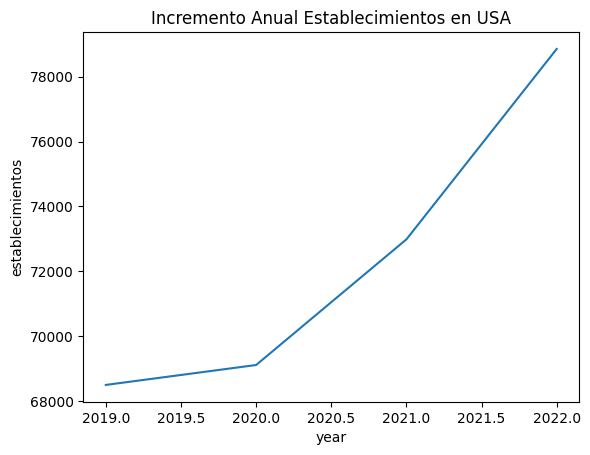

In [119]:
sns.lineplot(data=graph_data , x='year', y='establecimientos').set_title("Incremento Anual Establecimientos en USA")

Calcularemos el crecimiento anual por estado

In [120]:
cbp_concat_filtered = cbp_concat_filtered.sort_values(by=['state','year'])
cbp_concat_filtered["anual_growth"] = cbp_concat_filtered.groupby("state")["establishment_count"].pct_change() * 100

In [121]:
# visualizamos
cbp_concat_filtered

,state,year,establishment_count,anual_payroll(1000$),total_employees,anual_growth
0,Alabama,2019,486,67264,5059,NaN
0,Alabama,2020,522,77253,5724,7.407407
0,Alabama,2021,609,89981,6025,16.666667
0,Alabama,2022,711,115010,6824,16.748768
26,Alaska,2019,295,38522,2024,NaN
...,...,...,...,...,...,...
1420,Wisconsin,2022,1089,196514,11569,12.616339
1403,Wyoming,2019,139,16040,1025,NaN
1437,Wyoming,2020,124,21092,1121,-10.791367
1434,Wyoming,2021,150,22798,1330,20.967742


In [132]:
# Creamos un average para media de crecimiento anual de los ultimos años.
media_growth = cbp_concat_filtered.groupby("state").agg(media_crecimiento= ('anual_growth', 'mean'))
media_growth = media_growth.sort_values(by='media_crecimiento', ascending=False).reset_index()
media_growth.head(5)

,state,media_crecimiento
0,Mississippi,15.766117
1,Alabama,13.607614
2,Tennessee,13.250127
3,Iowa,11.704595
4,Idaho,11.602133


Text(0.5, 1.0, 'Top 5 Estados con Mayor crecimiento % anual')

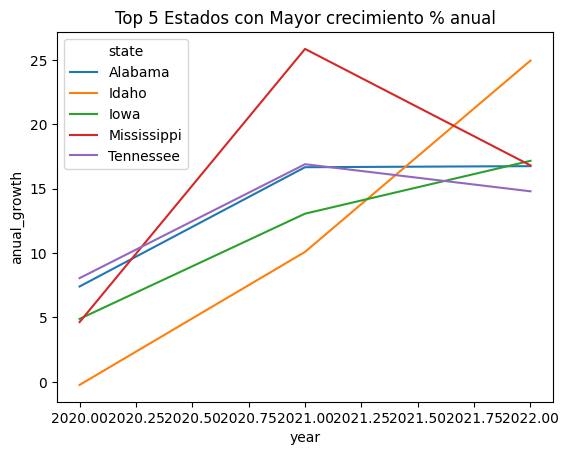

In [137]:
# vamos a graficar los estados con mayor crecimiento porcentual en los ultimos 5 años.
graph_data = pd.merge(cbp_concat_filtered, media_growth.head(5), on='state', how='inner')
sns.lineplot(data=graph_data, x='year', y='anual_growth', hue='state').set_title('Top 5 Estados con Mayor crecimiento % anual')

Text(0.5, 1.0, 'Bottom 5 Estados con Menor crecimiento % anual')

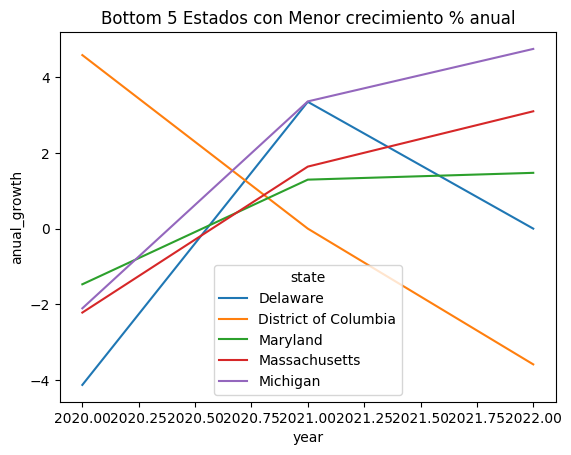

In [138]:
# vamos a graficar los estados con mayor crecimiento porcentual en los ultimos 5 años.
graph_data = pd.merge(cbp_concat_filtered, media_growth.tail(5), on='state', how='inner')
sns.lineplot(data=graph_data, x='year', y='anual_growth', hue='state').set_title('Bottom 5 Estados con Menor crecimiento % anual')